In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn import datasets
from sklearn import svm
from sklearn import metrics

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1' # Change me to store data elsewhere


In [4]:
def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
    
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

In [5]:
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified /Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified /Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_small.tar.gz


In [6]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
      os.path.join(root, d) for d in sorted(os.listdir(root))
      if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
        'Expected %d folders, one per class. Found %d instead.' % (
         num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large already present - Skipping extraction of /Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large.tar.gz.
['/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/A', '/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/B', '/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/C', '/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/D', '/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/E', '/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/F', '/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/G', '/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/H', '/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/I', '/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/J']


In [7]:
image_size = 28 #Pixel width and height
pixel_depth = 255.0 #Number of levels per pixel

def load_letter(folder, min_num_images):
    """Load the data for the single letter image"""
    image_file = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_file), image_size, image_size), 
                        dtype=np.float32)
    print(folder)
    num_images = 0
    for i, image in enumerate(image_file):
        image_file = os.path.join(folder, image)
        try:
            
            image_data = (ndimage.imread(image_file).astype(float) - 
                         pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[i,:,:]  = image_data
            num_images = i+1
        except IOError as e:
            print('Could not read: ', image_file, ':', e, '--skipping')
    
    dataset = dataset[0:num_images, :,:]
    if num_images < min_num_images:
        raise Exception('Too few images than expected: %d < %d' %
                       (num_images < min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Sigma:', np.std(dataset))
    return dataset

In [8]:
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present' % set_filename)
        else:
            print('Pickling %s' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names

In [9]:
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/A.pickle already present
/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/B.pickle already present
/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/C.pickle already present
/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/D.pickle already present
/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/E.pickle already present
/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/F.pickle already present
/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/G.pickle already present
/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/H.pickle already present
/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/I.pickle already present
/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/J.pickle already present


/Users/shivankurkapoor/Desktop/Study/ML/Udacity/Assignment1/notMNIST_large/A.pickle


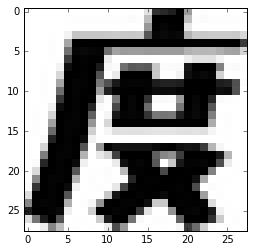

In [10]:
#Testing if images are good
pickle_file = train_datasets[0]
print(pickle_file)
with open(pickle_file, 'rb') as f:
    image_dataset = pickle.load(f)
sample_image = image_dataset[2] * pixel_depth + pixel_depth / 2
plt.imshow(sample_image, cmap='Greys', interpolation='nearest')

In [14]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [15]:
def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
              with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                  valid_letter = letter_set[:vsize_per_class, :, :]
                  valid_dataset[start_v:end_v, :, :] = valid_letter
                  valid_labels[start_v:end_v] = label
                  start_v += vsize_per_class
                  end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels

In [18]:
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

In [19]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [20]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [21]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
try:
    with open(pickle_file, 'wb') as f:
        save = {
            'train_dataset' : train_dataset,
            'train_labels'  : train_labels,
            'test_dataset'  : test_dataset,
            'test_labels'   : test_labels,
            'valid_dataset' : valid_dataset,
            'valid_labels'  : valid_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
except IOError as e:
    print('Unable to save data to ', pickle_file, ':', e)
    raise

In [24]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


In [26]:
logreg = linear_model.LogisticRegression()

In [27]:
logreg.fit(train_dataset.reshape((train_dataset.shape[0], -1)), train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
predict_valid = logreg.predict(valid_dataset.reshape((valid_dataset.shape[0], -1)))
logreg.score(valid_dataset.reshape((valid_dataset.shape[0], -1)), valid_labels)

0.82369999999999999

In [31]:
print(classification_report(valid_labels, predict_valid))

             precision    recall  f1-score   support

          0       0.86      0.83      0.85      1000
          1       0.84      0.80      0.82      1000
          2       0.82      0.87      0.85      1000
          3       0.85      0.84      0.84      1000
          4       0.83      0.75      0.79      1000
          5       0.83      0.88      0.85      1000
          6       0.83      0.83      0.83      1000
          7       0.83      0.81      0.82      1000
          8       0.75      0.79      0.77      1000
          9       0.80      0.83      0.82      1000

avg / total       0.82      0.82      0.82     10000

